In [7]:
import pandas as pd
import openpyxl
import seaborn as sb
import plotly as plt 
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf


### Combining the data from all sites into one set

In [3]:
# Path to the Excel file
file_path = r"C:\Users\aksel\OneDrive\Masaüstü\AgriAIChallenge\AgriAIChallenge\C2 - Grain-Only.xlsx"

# Load all sheets
xls = pd.ExcelFile(file_path)
sheets = xls.sheet_names

# Read each sheet and append to a list
dataframes = [xls.parse(sheet_name) for sheet_name in sheets]

# Concatenate all DataFrames into one
combined_df = pd.concat(dataframes, ignore_index=True)

# Show the combined DataFrame
print(combined_df.head())
copydf_grainonly = combined_df.copy()

# copydf_grainonly

         ET      NEE         ER        GPP   TMAX   TMIN   TAVG   HAVG   HDEG  \
0  1.617969 -2.828749  2.517847   5.346596  64.13  32.57  45.41  56.38  16.65   
1  0.360643  0.088979  1.672916   1.583937  54.61  22.20  34.70  44.08  26.60   
2  3.132401 -9.900786  6.451632  16.352418  70.39  38.83  53.87  63.12  10.39   
3  3.586924  0.220666  5.854790   5.634124  71.17  46.85  59.15  70.87   5.99   
4  2.952782 -0.110965  6.583431   6.694396  75.11  42.93  59.84  69.66   5.98   

   CDEG   WCMN   WSPD   ATOT  RAIN       EVI  
0   0.0  25.03  16.80  12.69  0.00  0.751000  
1   0.0  13.02   8.45  11.36  0.00  0.787000  
2   0.0  33.60   6.18  25.53  0.00  0.983000  
3   0.0  45.81  10.78  28.15  0.01  0.375000  
4   0.0  41.04   4.89  28.07  0.00  0.358222  


In [4]:
copydf_grainonly.describe()

,ET,NEE,ER,GPP,TMAX,TMIN,TAVG,HAVG,HDEG,CDEG,WCMN,WSPD,ATOT,RAIN,EVI
count,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000
mean,1.501818,-0.359853,2.551748,2.911601,61.044199,34.151192,47.078371,67.600066,17.878609,0.476238,-148.362424,-70.277987,-4.161205,0.056291,0.314390
std,1.048024,2.082363,1.651117,2.687527,14.162797,12.388434,12.249897,15.919842,11.478352,2.386358,383.368611,274.666442,131.540531,0.181482,0.197022
min,-0.368483,-13.211302,0.573142,0.068792,16.110000,-0.290000,9.790000,31.070000,0.000000,0.000000,-996.000000,-996.000000,-996.000000,0.000000,0.094000
25%,0.746622,-1.179107,1.555234,0.991610,52.680000,26.300000,38.760000,55.870000,9.335000,0.000000,12.190000,7.290000,8.970000,0.000000,0.122200
50%,1.259801,0.036701,2.166784,2.254483,61.790000,32.520000,46.690000,67.270000,17.890000,0.000000,21.660000,9.470000,12.310000,0.000000,0.261333
75%,1.966624,0.866519,2.797170,4.008380,71.580000,41.230000,55.500000,78.860000,25.970000,0.000000,29.230000,13.240000,17.100000,0.010000,0.480000
max,6.431177,6.518080,12.959193,21.842996,94.620000,76.820000,85.280000,99.060000,53.850000,20.720000,48.980000,23.840000,30.200000,3.200000,1.074000


## A.1

### Exploratory data analysis with correlation heatmap

<module 'plotly' from 'C:\\Users\\aksel\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\plotly\\__init__.py'>

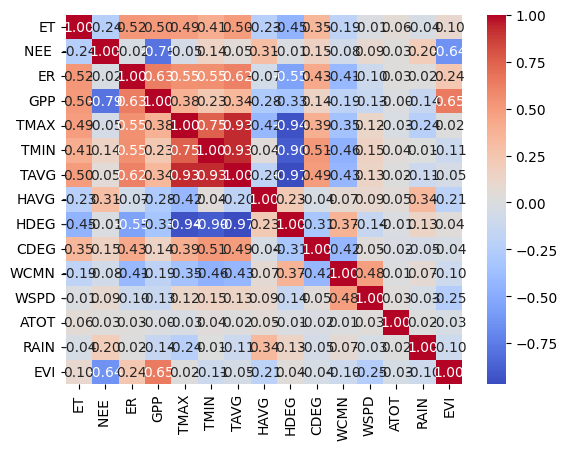

In [5]:
# Calculate the correlation matrix
correlation_matrix = copydf_grainonly.corr()

# Create the heatmap

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap = 'coolwarm')
plt

## A.2

### Spearman on EVI

In [6]:
# Compute the Spearman correlation matrix
spearman_corr = copydf_grainonly.corr(method='spearman')

# Display the correlation coefficients with EVI
spearman_corr_evi = spearman_corr['EVI'].sort_values(ascending=False)
spearman_corr_evi

EVI     1.000000
GPP     0.749694
ER      0.381888
ATOT    0.206128
ET      0.104123
TMAX    0.073859
TAVG    0.025166
CDEG   -0.009016
HDEG   -0.029996
TMIN   -0.051737
WCMN   -0.072536
WSPD   -0.093511
RAIN   -0.127899
HAVG   -0.234938
NEE    -0.664961
Name: EVI, dtype: float64

### SEM on flux attributes

In [9]:
models = {
    'ET': 'ET ~ TMAX + TMIN + TAVG + HAVG',
    'NEE': 'NEE ~ TMAX + TMIN + TAVG + HAVG',
    'ER': 'ER ~ TMAX + TMIN + TAVG + HAVG',
    'GPP': 'GPP ~ TMAX + TMIN + TAVG + HAVG'
}

In [10]:
# Correct the column names by stripping whitespace
copydf_grainonly.columns = copydf_grainonly.columns.str.strip()

# Retry fitting the models
results_corrected = {}
for flux_attribute, formula in models.items():
    model = smf.ols(formula, data=copydf_grainonly)
    results_corrected[flux_attribute] = model.fit()

# Display the summary for each corrected model
model_summaries = {flux_attribute: result.summary().as_text() for flux_attribute, result in results_corrected.items()}
model_summaries


{'ET': '                            OLS Regression Results                            \n==============================================================================\nDep. Variable:                     ET   R-squared:                       0.281\nModel:                            OLS   Adj. R-squared:                  0.277\nMethod:                 Least Squares   F-statistic:                     73.32\nDate:                Mon, 15 Apr 2024   Prob (F-statistic):           1.87e-52\nTime:                        13:18:10   Log-Likelihood:                -981.61\nNo. Observations:                 755   AIC:                             1973.\nDf Residuals:                     750   BIC:                             1996.\nDf Model:                           4                                         \nCovariance Type:            nonrobust                                         \n==============================================================================\n                 coef    std err

## A.3

### Identifying key attributes

In [11]:
# Create a condensed summary of results
condensed_summaries = {}

for flux_attribute, result in results_corrected.items():
    # Extract key results
    r_squared = result.rsquared
    adj_r_squared = result.rsquared_adj
    significant_predictors = result.pvalues[result.pvalues < 0.05]
    predictors_summary = ", ".join([f"{pred} (coef={result.params[pred]:.3f}, p={result.pvalues[pred]:.3f})" 
                                    for pred in significant_predictors.index if pred != "Intercept"])
    
    # Create a compact summary
    condensed_summary = (f"Dependent Variable: {flux_attribute}\n"
                         f"R-squared: {r_squared:.3f}, Adjusted R-squared: {adj_r_squared:.3f}\n"
                         f"Significant Predictors: {predictors_summary if predictors_summary else 'None'}\n")
    
    condensed_summaries[flux_attribute] = condensed_summary

# Display the condensed summaries
for attribute, summary in condensed_summaries.items():
    print(summary + "\n---\n")


Dependent Variable: ET
R-squared: 0.281, Adjusted R-squared: 0.277
Significant Predictors: TMAX (coef=-0.029, p=0.004), TMIN (coef=-0.041, p=0.000), TAVG (coef=0.110, p=0.000), HAVG (coef=-0.008, p=0.003)

---

Dependent Variable: NEE
R-squared: 0.112, Adjusted R-squared: 0.108
Significant Predictors: HAVG (coef=0.034, p=0.000)

---

Dependent Variable: ER
R-squared: 0.414, Adjusted R-squared: 0.411
Significant Predictors: TMAX (coef=-0.065, p=0.000), TMIN (coef=-0.090, p=0.000), TAVG (coef=0.239, p=0.000), HAVG (coef=0.008, p=0.048)

---

Dependent Variable: GPP
R-squared: 0.176, Adjusted R-squared: 0.171
Significant Predictors: TMIN (coef=-0.100, p=0.001), TAVG (coef=0.198, p=0.000), HAVG (coef=-0.026, p=0.001)

---



In [23]:
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Part B

### Building predictive regression models for each flux attribute

In [28]:
# Selecting features and target
features = copydf_grainonly[['TMAX', 'TMIN', 'TAVG', 'HAVG', 'HDEG', 'CDEG', 'WCMN', 'WSPD', 'ATOT', 'RAIN', 'EVI']]
target = copydf_grainonly['ET']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Building the regression model
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Predicting on the test set
y_pred = reg_model.predict(X_test)

# Evaluating the model
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print("MAE : ")
print(mae)
print("RMSE: ")
print(rmse)
print("R2 score: ")
print(r2)

MAE : 
0.6269211764741075
RMSE: 
0.9106141669097984
R2 score: 
0.3353240769132839


In [29]:
# Selecting features and target
features = copydf_grainonly[['TMAX', 'TMIN', 'TAVG', 'HAVG', 'HDEG', 'CDEG', 'WCMN', 'WSPD', 'ATOT', 'RAIN', 'EVI']]
target = copydf_grainonly['NEE']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Building the regression model
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Predicting on the test set
y_pred = reg_model.predict(X_test)

# Evaluating the model
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print("MAE : ")
print(mae)
print("RMSE: ")
print(rmse)
print("R2 score: ")
print(r2)

MAE : 
1.1695140616628374
RMSE: 
1.7827598881724145
R2 score: 
0.49474390016999914


In [30]:
# Selecting features and target
features = copydf_grainonly[['TMAX', 'TMIN', 'TAVG', 'HAVG', 'HDEG', 'CDEG', 'WCMN', 'WSPD', 'ATOT', 'RAIN', 'EVI']]
target = copydf_grainonly['ER']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Building the regression model
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Predicting on the test set
y_pred = reg_model.predict(X_test)

# Evaluating the model
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print("MAE : ")
print(mae)
print("RMSE: ")
print(rmse)
print("R2 score: ")
print(r2)

MAE : 
0.7552685898411235
RMSE: 
1.2341811408342622
R2 score: 
0.5567067144436925


In [31]:
# Selecting features and target
features = copydf_grainonly[['TMAX', 'TMIN', 'TAVG', 'HAVG', 'HDEG', 'CDEG', 'WCMN', 'WSPD', 'ATOT', 'RAIN', 'EVI']]
target = copydf_grainonly['GPP']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Building the regression model
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Predicting on the test set
y_pred = reg_model.predict(X_test)

# Evaluating the model
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print("MAE : ")
print(mae)
print("RMSE: ")
print(rmse)
print("R2 score: ")
print(r2)


MAE : 
1.110498389595125
RMSE: 
1.9128186647351932
R2 score: 
0.604181191982391


## 5.a

In [32]:
# Selecting features and target
features = copydf_grainonly[['TMAX', 'TMIN', 'TAVG', 'HAVG', 'HDEG', 'CDEG', 'WCMN', 'WSPD', 'ATOT', 'RAIN', 'NEE', 'EVI']]
target = copydf_grainonly['ET']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Building the regression model
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Predicting on the test set
y_pred = reg_model.predict(X_test)

# Evaluating the model
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print("MAE : ")
print(mae)
print("RMSE: ")
print(rmse)
print("R2 score: ")
print(r2)


MAE : 
0.5774141441397249
RMSE: 
0.8408159424502218
R2 score: 
0.4333133032703712


## 5.b

In [37]:
# Selecting features and target
features = copydf_grainonly[['TMAX', 'TMIN', 'TAVG', 'HAVG', 'HDEG', 'CDEG', 'WCMN', 'WSPD', 'ATOT', 'RAIN', 'ET', 'EVI']]
target = copydf_grainonly['NEE']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Building the regression model
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Predicting on the test set
y_pred = reg_model.predict(X_test)

# Evaluating the model
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print("MAE : ")
print(mae)
print("RMSE: ")
print(rmse)
print("R2 score: ")
print(r2)


MAE : 
1.1397094081832906
RMSE: 
1.6621178915146801
R2 score: 
0.5608129699110387


## 5.c

In [38]:
# Selecting features and target
features = copydf_grainonly[['TMAX', 'TMIN', 'TAVG', 'HAVG', 'HDEG', 'CDEG', 'WCMN', 'WSPD', 'ATOT', 'RAIN', 'NEE', 'ET', 'EVI']]
target = copydf_grainonly['ER']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Building the regression model
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Predicting on the test set
y_pred = reg_model.predict(X_test)

# Evaluating the model
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print("MAE : ")
print(mae)
print("RMSE: ")
print(rmse)
print("R2 score: ")
print(r2)


MAE : 
0.7292587699492309
RMSE: 
1.1515206292241458
R2 score: 
0.6140982154459034


## 6

In [51]:
from sklearn.feature_selection import RFE

# Prepare features and target variable for ET
features = copydf_grainonly[['TMAX', 'TMIN', 'TAVG', 'HAVG', 'HDEG', 'CDEG', 'WCMN', 'WSPD', 'ATOT', 'RAIN', 'EVI']]
target = copydf_grainonly['ET']

# Initialize and fit the linear regression model
lr = LinearRegression()
lr.fit(features, target)

# Display the coefficients from the linear model
coefficients = pd.DataFrame({
    'Feature': features.columns,
    'Coefficient': lr.coef_,
    'Absolute Coefficient': abs(lr.coef_)
}).sort_values(by='Absolute Coefficient', ascending=False)

# Initialize RFE with linear regression as the estimator
rfe = RFE(estimator=LinearRegression(), n_features_to_select=1)
rfe.fit(features, target)

# RFE Ranking
rfe_ranking = pd.DataFrame({
    'Feature': features.columns,
    'Ranking': rfe.ranking_
}).sort_values(by='Ranking')

coefficients, rfe_ranking


(   Feature  Coefficient  Absolute Coefficient
 4     HDEG     9.635369              9.635369
 5     CDEG    -9.549527              9.549527
 0     TMAX     4.801450              4.801450
 1     TMIN     4.783968              4.783968
 10     EVI     0.472342              0.472342
 9     RAIN     0.398802              0.398802
 2     TAVG     0.089509              0.089509
 3     HAVG    -0.007043              0.007043
 8     ATOT     0.000477              0.000477
 7     WSPD    -0.000430              0.000430
 6     WCMN     0.000417              0.000417,
    Feature  Ranking
 5     CDEG        1
 0     TMAX        2
 4     HDEG        3
 1     TMIN        4
 10     EVI        5
 9     RAIN        6
 2     TAVG        7
 3     HAVG        8
 8     ATOT        9
 7     WSPD       10
 6     WCMN       11)

In [52]:
# Prepare features and target variable for ET
features = copydf_grainonly[['TMAX', 'TMIN', 'TAVG', 'HAVG', 'HDEG', 'CDEG', 'WCMN', 'WSPD', 'ATOT', 'RAIN', 'EVI']]
target = copydf_grainonly['NEE']

# Initialize and fit the linear regression model
lr = LinearRegression()
lr.fit(features, target)

# Display the coefficients from the linear model
coefficients = pd.DataFrame({
    'Feature': features.columns,
    'Coefficient': lr.coef_,
    'Absolute Coefficient': abs(lr.coef_)
}).sort_values(by='Absolute Coefficient', ascending=False)

# Initialize RFE with linear regression as the estimator
rfe = RFE(estimator=LinearRegression(), n_features_to_select=1)
rfe.fit(features, target)

# RFE Ranking
rfe_ranking = pd.DataFrame({
    'Feature': features.columns,
    'Ranking': rfe.ranking_
}).sort_values(by='Ranking')

coefficients, rfe_ranking


(   Feature  Coefficient  Absolute Coefficient
 4     HDEG    39.308613             39.308613
 5     CDEG   -39.209816             39.209816
 0     TMAX    19.658294             19.658294
 1     TMIN    19.647964             19.647964
 10     EVI    -6.506588              6.506588
 9     RAIN     1.047428              1.047428
 3     HAVG     0.022192              0.022192
 2     TAVG    -0.003856              0.003856
 6     WCMN    -0.000641              0.000641
 7     WSPD    -0.000145              0.000145
 8     ATOT    -0.000051              0.000051,
    Feature  Ranking
 1     TMIN        1
 4     HDEG        2
 5     CDEG        3
 0     TMAX        4
 10     EVI        5
 9     RAIN        6
 3     HAVG        7
 2     TAVG        8
 6     WCMN        9
 7     WSPD       10
 8     ATOT       11)

In [53]:
# Prepare features and target variable for ET
features = copydf_grainonly[['TMAX', 'TMIN', 'TAVG', 'HAVG', 'HDEG', 'CDEG', 'WCMN', 'WSPD', 'ATOT', 'RAIN', 'EVI']]
target = copydf_grainonly['ER']

# Initialize and fit the linear regression model
lr = LinearRegression()
lr.fit(features, target)

# Display the coefficients from the linear model
coefficients = pd.DataFrame({
    'Feature': features.columns,
    'Coefficient': lr.coef_,
    'Absolute Coefficient': abs(lr.coef_)
}).sort_values(by='Absolute Coefficient', ascending=False)

# Initialize RFE with linear regression as the estimator
rfe = RFE(estimator=LinearRegression(), n_features_to_select=1)
rfe.fit(features, target)

# RFE Ranking
rfe_ranking = pd.DataFrame({
    'Feature': features.columns,
    'Ranking': rfe.ranking_
}).sort_values(by='Ranking')

coefficients, rfe_ranking


(   Feature  Coefficient  Absolute Coefficient
 5     CDEG    27.929566             27.929566
 4     HDEG   -27.825469             27.825469
 1     TMIN   -14.009733             14.009733
 0     TMAX   -13.960012             13.960012
 10     EVI     2.258374              2.258374
 9     RAIN     0.923280              0.923280
 2     TAVG     0.218687              0.218687
 3     HAVG     0.015813              0.015813
 7     WSPD    -0.000487              0.000487
 8     ATOT     0.000410              0.000410
 6     WCMN    -0.000337              0.000337,
    Feature  Ranking
 5     CDEG        1
 4     HDEG        2
 1     TMIN        3
 0     TMAX        4
 10     EVI        5
 9     RAIN        6
 2     TAVG        7
 3     HAVG        8
 7     WSPD        9
 8     ATOT       10
 6     WCMN       11)

In [55]:
# Prepare features and target variable for ET
features = copydf_grainonly[['TMAX', 'TMIN', 'TAVG', 'HAVG', 'HDEG', 'CDEG', 'WCMN', 'WSPD', 'ATOT', 'RAIN', 'EVI']]
target = copydf_grainonly['GPP']

# Initialize and fit the linear regression model
lr = LinearRegression()
lr.fit(features, target)

# Display the coefficients from the linear model
coefficients = pd.DataFrame({
    'Feature': features.columns,
    'Coefficient': lr.coef_,
    'Absolute Coefficient': abs(lr.coef_)
}).sort_values(by='Absolute Coefficient', ascending=False)

# Initialize RFE with linear regression as the estimator
rfe = RFE(estimator=LinearRegression(), n_features_to_select=1)
rfe.fit(features, target)

# RFE Ranking
rfe_ranking = pd.DataFrame({
    'Feature': features.columns,
    'Ranking': rfe.ranking_
}).sort_values(by='Ranking')

coefficients, rfe_ranking


(   Feature  Coefficient  Absolute Coefficient
 5     CDEG    67.139381             67.139381
 4     HDEG   -67.134082             67.134082
 1     TMIN   -33.657697             33.657697
 0     TMAX   -33.618306             33.618306
 10     EVI     8.764962              8.764962
 2     TAVG     0.222542              0.222542
 9     RAIN    -0.124148              0.124148
 3     HAVG    -0.006379              0.006379
 8     ATOT     0.000461              0.000461
 7     WSPD    -0.000343              0.000343
 6     WCMN     0.000304              0.000304,
    Feature  Ranking
 4     HDEG        1
 5     CDEG        2
 1     TMIN        3
 0     TMAX        4
 10     EVI        5
 2     TAVG        6
 9     RAIN        7
 3     HAVG        8
 8     ATOT        9
 7     WSPD       10
 6     WCMN       11)